# Performance Attribution #

In [1]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_daily_financial_data
from factors_toolkit import FamaFrenchFactors

In [6]:
# Now import the premiums
premiums_df = pd.read_csv(r'..\additional_data\famafrench_premiums.csv')
premiums_df.set_index('Date', inplace=True)
premiums_df.index = pd.to_datetime(premiums_df.index)
premiums_df.columns = ['mkt_premium', 'smb_premium', 'hml_premium', 'risk_free_rate']
premiums_df = premiums_df.div(100)

premiums_df

,mkt_premium,smb_premium,hml_premium,risk_free_rate
Date,,,,
2015-01-02,-0.0012,-0.0059,0.0012,0.00000
2015-01-05,-0.0184,0.0033,-0.0068,0.00000
2015-01-06,-0.0103,-0.0080,-0.0029,0.00000
2015-01-07,0.0119,0.0020,-0.0067,0.00000
2015-01-08,0.0181,-0.0012,-0.0029,0.00000
...,...,...,...,...
2025-03-25,0.0012,-0.0094,0.0005,0.00016
2025-03-26,-0.0122,-0.0048,0.0152,0.00016
2025-03-27,-0.0042,0.0019,0.0030,0.00016


In [8]:
# And we can import the betas
ff_betas = pd.read_csv(r'..\additional_data\famafrench_betas.csv')
ff_betas.rename(columns={'Unnamed: 0': 'stocks'}, inplace=True)
ff_betas.set_index('stocks', inplace=True)

ff_betas

,mkt_beta,smb_beta,hml_beta
stocks,,,
A,0.955686,0.079807,-0.134990
AAPL,1.161827,-0.290220,-0.378872
ABBV,0.616293,-0.301336,0.108055
ABT,0.786172,-0.290043,-0.130577
ADBE,1.253717,-0.235385,-0.681084
...,...,...,...
XYL,1.039345,0.146356,0.256511
YUM,0.760846,-0.183805,0.146926
ZBH,0.830569,0.124457,0.241640


### Fama and French Attribution ###

In [30]:
# Import Stock Data
ticker = 'MSFT'

# Import Data
data_stock = import_daily_financial_data(
    ticker=ticker, 
    start_date='2015-01-01', 
    end_date='2025-01-01', 
    returns=True
)

data_stock

[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume,returns
Date,,,,,,
2015-01-05,39.630886,39.973046,39.562452,39.665100,39673900,-0.009238
2015-01-06,39.049198,39.990141,38.955103,39.673643,36447900,-0.014786
2015-01-07,39.545353,39.742096,38.912355,39.331502,29114100,0.012626
2015-01-08,40.708687,40.845551,39.964486,39.990147,29645200,0.028993
2015-01-09,40.366520,40.905425,40.118455,40.725791,23944200,-0.008441
...,...,...,...,...,...,...
2024-12-24,437.647400,437.916385,432.527101,432.985331,7164500,0.009330
2024-12-26,436.432068,439.251246,434.957756,437.398354,8194200,-0.002781
2024-12-27,428.881104,433.553144,424.717120,432.935523,18117700,-0.017453


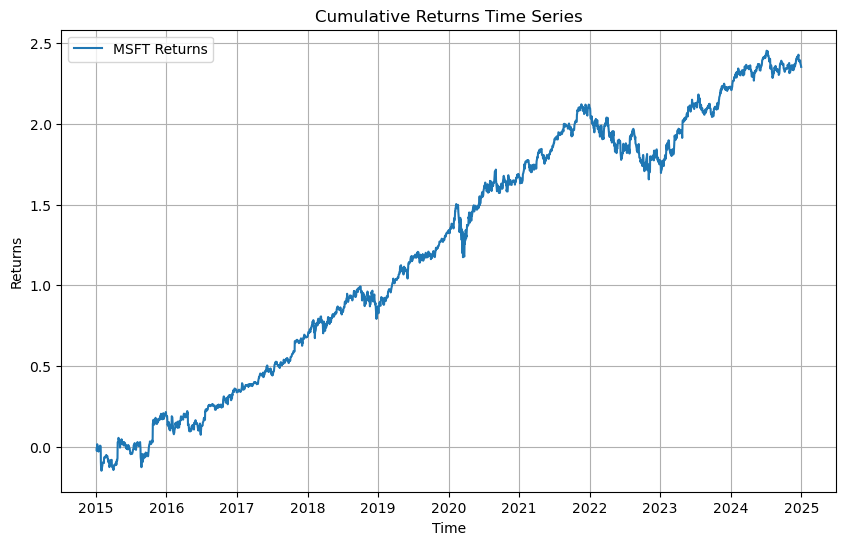

In [31]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(data_stock['returns'].cumsum(), label=f'{ticker} Returns', alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [32]:
# Now let us calculate the returns according to the beta
mkt_contribution = ff_betas.loc[ticker]['mkt_beta'] * premiums_df['mkt_premium']
mkt_contribution.name = 'mkt_contribution'

# For Size
size_contribution = ff_betas.loc[ticker]['smb_beta'] * premiums_df['smb_premium']
size_contribution.name = 'size_contribution'

# For Value
value_contribution = ff_betas.loc[ticker]['hml_beta'] * premiums_df['hml_premium']
value_contribution.name = 'value_contribution'

In [33]:
# And to calculate the residuals we just have to take the difference
residual_returns = data_stock['returns'] - (mkt_contribution + size_contribution + value_contribution)

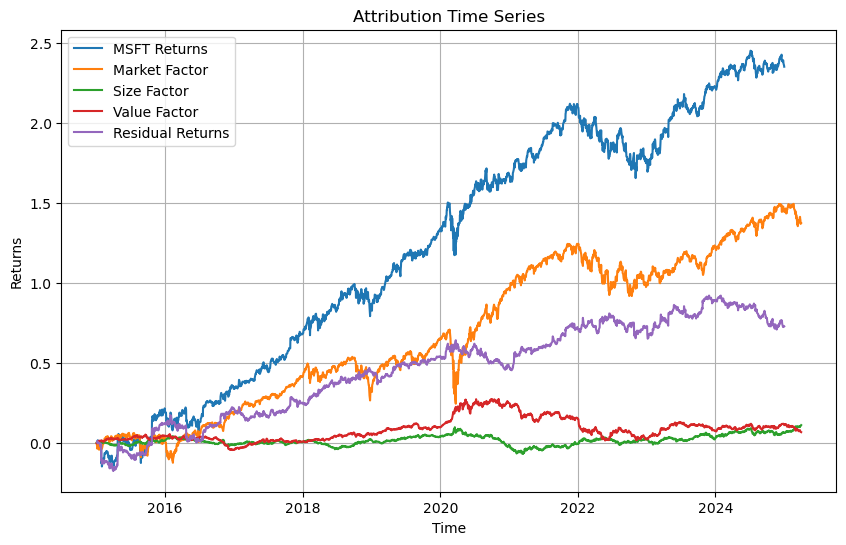

In [34]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(data_stock['returns'].cumsum(), label=f'{ticker} Returns', alpha=1)
plt.plot(mkt_contribution.cumsum(), label='Market Factor', alpha=1)
plt.plot(size_contribution.cumsum(), label='Size Factor', alpha=1)
plt.plot(value_contribution.cumsum(), label='Value Factor', alpha=1)
plt.plot(residual_returns.cumsum(), label='Residual Returns', alpha=1)

# Config
plt.title('Attribution Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show() 

### Brinson-Fachley Model ###

In [35]:
# We have to obtain data for our benchmark

# iShares U.S. Technology ETF
data_iwy = import_daily_financial_data(
    ticker='IWY', 
    start_date='2015-01-01', 
    end_date='2025-01-01', 
    returns=True
)

data_iwy

[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume,returns
Date,,,,,,
2015-01-05,44.562851,45.174781,44.481860,45.174781,26600,-0.016821
2015-01-06,44.148907,44.742838,44.049918,44.652846,20700,-0.009332
2015-01-07,44.715843,44.751840,44.445875,44.652851,11700,0.012760
2015-01-08,45.543736,45.597727,45.147779,45.174778,15600,0.018345
2015-01-09,45.201790,45.714730,45.030811,45.714730,26900,-0.007536
...,...,...,...,...,...,...
2024-12-24,243.761948,243.761948,241.094882,241.184780,140800,0.013657
2024-12-26,243.322418,243.991680,241.864031,243.042727,281300,-0.001805
2024-12-27,239.776321,241.874021,237.598723,241.684227,233400,-0.014681


In [38]:
# Now calculate the betas
iwy_premium = data_iwy['returns'] - premiums_df['risk_free_rate']

# Check if the Function Works
parameters = FamaFrenchFactors(
    iwy_premium,
    premiums_df['mkt_premium'],
    premiums_df['smb_premium'],
    premiums_df['hml_premium'],
)

parameters

{'alpha': 3.934729822390897e-05,
 'mkt_beta': 1.0759611426862992,
 'smb_beta': -0.2011898749077647,
 'hml_beta': -0.32820174884501496}